# SI630: Final Project code for 4_prog_mngmt classification task



***  

# 1. Loading Data

In [1]:
import os
import json, csv
import re

import pandas as pd
import spacy
import sklearn
from glob import glob
from pprint import pprint

#import pickle
from collections import Counter, defaultdict
import numpy as np
#from numpy import argmax
import scipy
import seaborn as sns
import matplotlib
import math
import random
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords 
set(stopwords.words('english'))   
#from numba import jit
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve


import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
monster_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/monster_com-job_with_label_columns.csv.xlsx", 
                 error_bad_lines=False, sheet_name="monster_com-job_sample", na_filter=False, encoding= 'utf-8')

In [3]:
monster_df = monster_df.replace({'T':True, 'F':False, '':np.nan})

***  

# 2. Pre-processing: Text Cleaning

In [4]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # Remove Emails
    text = re.sub(r"\S*@\S*\s?", "", text)
    
    # Remove new line characters
    text = re.sub(r"\s+", " ", text)
    
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    
    # Convert text to lowercase
    text = text.strip().lower()
    
    # Remove entity abbreviations
    # Add \b in redgex so that it creates word boundary -(e.g) the word, company, remains company.
    text = re.sub(r",?\s*\b(llc|inc|co)\b\.?", "", text)
    
    # Replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

#pprint(text)
    return text


In [5]:
labeled_rows = monster_df.loc[~monster_df['1_self_mngmt'].isnull()]

In [6]:
X = labeled_rows['job_description']
y = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

***  

### Class Distribution Graph for 215 labeled rows

In [7]:
import seaborn as sns; sns.set()
sns.set_color_codes()

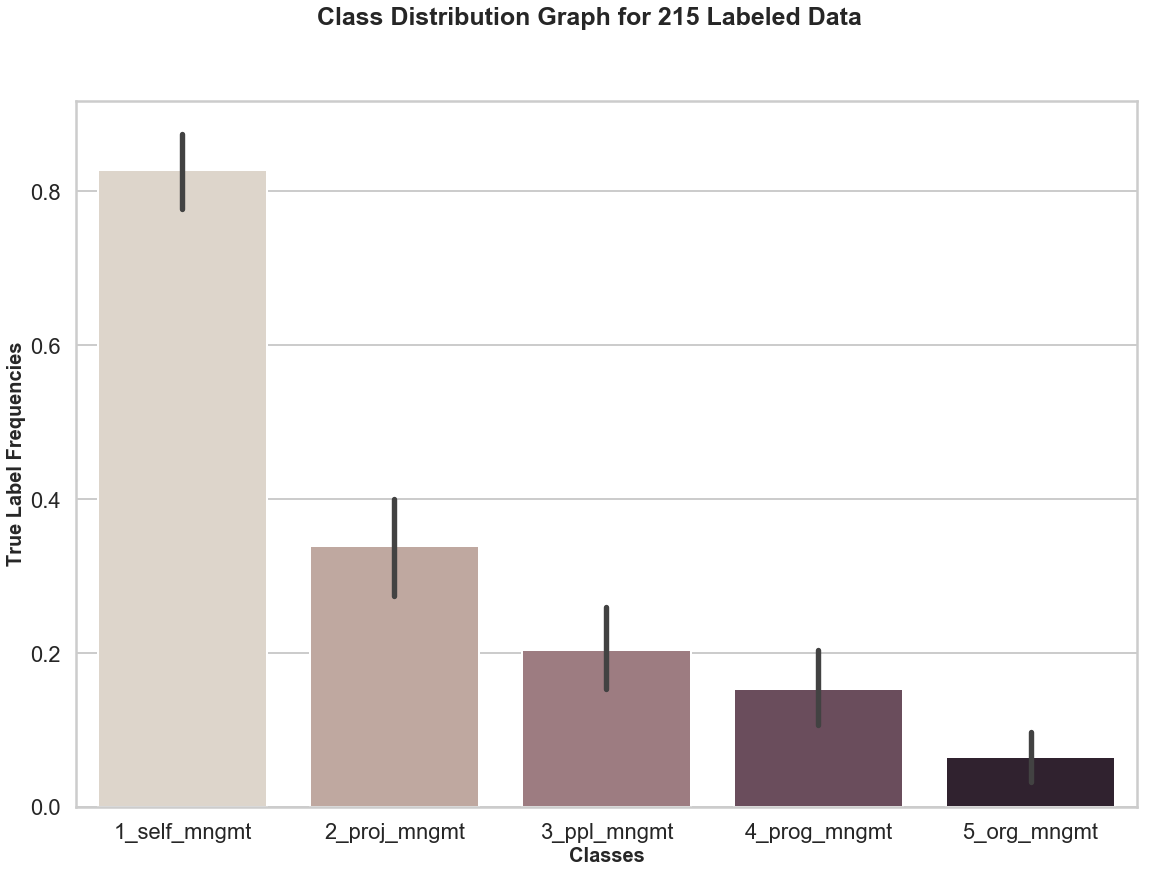

In [8]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(1, figsize=(19, 13))
sns.barplot(data=y, palette="ch:.25", saturation=.5)
plt.suptitle("Class Distribution Graph for 215 Labeled Data", fontsize=25, weight = 'bold')
plt.xlabel('Classes', fontsize=20, weight = 'bold')
plt.ylabel('True Label Frequencies', fontsize=20, weight = 'bold')
plt.show()

***  

# 3. Building A Basic LR Model

In [9]:
stopwords_lst = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

count_vectorizer = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=3, max_df=0.5)

# fit the vectorizer on the training text
X_train = count_vectorizer.fit_transform(X_train) 
X_test = count_vectorizer.transform(X_test) #

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


In [11]:
#count_vectorizer.vocabulary_

In [12]:
X_train

<144x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 17237 stored elements in Compressed Sparse Row format>

In [13]:
X_test

<71x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 7844 stored elements in Compressed Sparse Row format>

In [14]:
y_train = y_train.astype('bool') #(134,5)
#y_train

In [15]:
y_test = y_test.astype('bool') #(12, 5)
y_test.mean()

1_self_mngmt    0.816901
2_proj_mngmt    0.352113
3_ppl_mngmt     0.183099
4_prog_mngmt    0.126761
5_org_mngmt     0.112676
dtype: float64

In [16]:
# count_vectorizer.vocabulary_

In [17]:
X_train

<144x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 17237 stored elements in Compressed Sparse Row format>

In [18]:
X_test
X_test 

<71x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 7844 stored elements in Compressed Sparse Row format>

In [19]:
y_train = y_train.astype('bool') #(23, 5)

***  

# 4. Training The Model & Predicting

In [20]:
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced').fit(X_train, y_train["4_prog_mngmt"])

In [21]:
y_pred = classifier.predict(X_test) #Predict class labels for samples in X
y_pred
#X_train.shape #(16, 1306)
#y_train.shape #(16, 5)
#X_test.shape #(9, 1306)
#y_test.shape #(16, 5)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False])

In [22]:
classifier.predict_proba(X_test) #Probability estimates 

array([[0.53859295, 0.46140705],
       [0.65895258, 0.34104742],
       [0.67733612, 0.32266388],
       [0.58065438, 0.41934562],
       [0.48091403, 0.51908597],
       [0.75904728, 0.24095272],
       [0.67775867, 0.32224133],
       [0.53508389, 0.46491611],
       [0.60070072, 0.39929928],
       [0.64229013, 0.35770987],
       [0.65652677, 0.34347323],
       [0.5858349 , 0.4141651 ],
       [0.55285473, 0.44714527],
       [0.65638466, 0.34361534],
       [0.65473453, 0.34526547],
       [0.69987535, 0.30012465],
       [0.7309222 , 0.2690778 ],
       [0.66425666, 0.33574334],
       [0.51365743, 0.48634257],
       [0.45445435, 0.54554565],
       [0.68681077, 0.31318923],
       [0.51819014, 0.48180986],
       [0.56756842, 0.43243158],
       [0.45910888, 0.54089112],
       [0.54920415, 0.45079585],
       [0.51416623, 0.48583377],
       [0.57114419, 0.42885581],
       [0.6457872 , 0.3542128 ],
       [0.47186871, 0.52813129],
       [0.56850996, 0.43149004],
       [0.

***  

# 5. Measurements/ Metrics from the base LR:  

***  

### (1) Accuracy Score

In [23]:
base_lr_accuracy_score = classifier.score(X_test, y_test["4_prog_mngmt"])
base_lr_accuracy_score

0.9154929577464789

***  

### (2) F1 Score

In [24]:
print(f1_score(y_test["4_prog_mngmt"], y_pred, average='weighted'))  
print(f1_score(y_test["4_prog_mngmt"], y_pred, average='macro'))  
print(f1_score(y_test["4_prog_mngmt"], y_pred, average='micro'))  
# print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='weighted'))

0.9190256291849459
0.8254098360655738
0.9154929577464789


In [25]:
log_loss(y_test["4_prog_mngmt"], y_pred, eps=1e-15)

2.9188148839321824

***  
### (4) ROC AUC Score

In [26]:
# We need some probabilities:
predicted_prob = classifier.predict_proba(X_test)
roc_auc_score(y_test["4_prog_mngmt"].astype(bool), predicted_prob[:,1])

0.9318996415770608

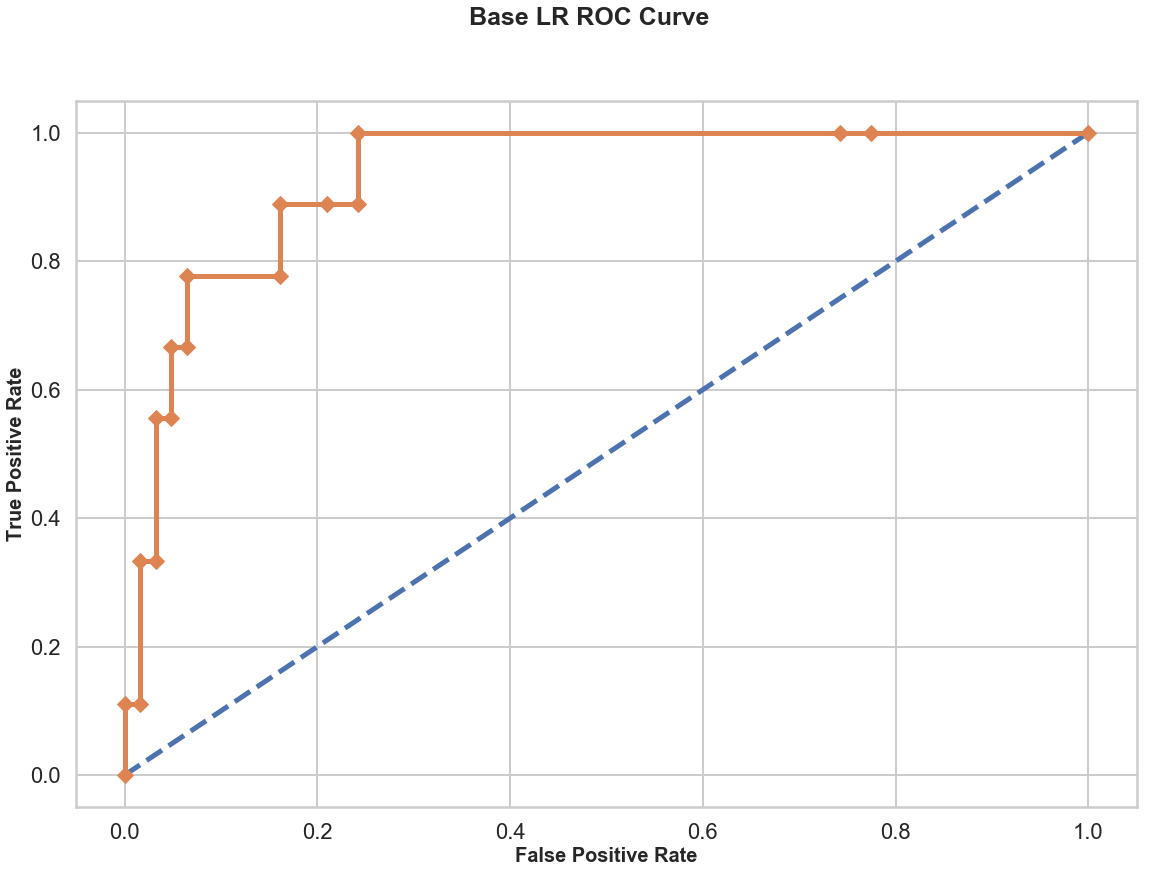

In [27]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(19,13))

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test["4_prog_mngmt"], predicted_prob[:,1])

plt.suptitle("Base LR ROC Curve", fontsize=25, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize=20, weight = 'bold')

# The blue dotted diagonal line indicates randomness.
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5)
# The solid orange line indictaes the roc curve for the model
plt.plot(fpr, tpr, marker='D', linewidth=5)
# show the plot
plt.show()

***  

### (5) Classification Report

In [28]:
target_names = ['False', 'True']
print(classification_report(y_test["4_prog_mngmt"].astype(int), y_pred, target_names=target_names))

              precision    recall  f1-score   support

       False       0.97      0.94      0.95        62
        True       0.64      0.78      0.70         9

   micro avg       0.92      0.92      0.92        71
   macro avg       0.80      0.86      0.83        71
weighted avg       0.92      0.92      0.92        71



***  
### Baseline Results: Making predictions for unlabeled data

In [29]:
# Now we will find unlabeled rows for '2_proj_mngmt':
unlabeled_rows = monster_df.loc[monster_df['4_prog_mngmt'].isnull()]
unlabeled_rows = unlabeled_rows.dropna(subset=["job_description"])

In [30]:
# Preproccessing
X_unlabeled = unlabeled_rows['job_description']
#y = unlabeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']] --> I don't need this.

In [31]:
X_unlabeled = count_vectorizer.transform(X_unlabeled)
X_unlabeled_tf = tfidf_transformer.transform(X_unlabeled)

In [32]:
unlabeled_pred_result = classifier.predict_proba(X_unlabeled)
unlabeled_pred_result #Probability estimates --> Look for the values, where the differece between x and y values are smallest

array([[9.74006616e-01, 2.59933840e-02],
       [1.25406352e-11, 1.00000000e+00],
       [1.33643075e-07, 9.99999866e-01],
       ...,
       [8.08137703e-01, 1.91862297e-01],
       [9.75987406e-01, 2.40125935e-02],
       [5.74258485e-02, 9.42574152e-01]])

In [33]:
unlabeled_rows["prob_false"] = unlabeled_pred_result[:,0]
unlabeled_rows["prob_true"] = unlabeled_pred_result[:,1]
unlabeled_rows["label_prob_diff"] = unlabeled_rows["prob_false"] - unlabeled_rows["prob_true"]
unlabeled_rows[["prob_false", "prob_true", "label_prob_diff"]].sort_values(by="label_prob_diff", ascending=False)
subset = unlabeled_rows[unlabeled_rows["label_prob_diff"].between(0.0,0.3)] #Use func, between.
subset = subset[["prob_false", "prob_true", "label_prob_diff", "uniq_id" ]].sort_values(by="label_prob_diff", ascending=True)

***  

# 5. (1) Building Pipeline: Improve classification: LR with LDA


In [34]:
X_labeled_text = labeled_rows['job_description'] #Text job descriptions
y_labeled = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

In [35]:
X_all = monster_df["job_description"].dropna()

In [36]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# Define Search Param
search_params = {'n_components': [40, 45, 50], 'learning_decay': [0.7, 0.8, 0.9], 
                 'C': [0.85, 1.0]}

grid = ParameterGrid(search_params)

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()

for params in grid:
    best_lda_model = LatentDirichletAllocation(n_components=params['n_components'], 
                                               learning_decay=params['learning_decay'], 
                                               max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
    best_lda_model.fit(X_bow) # Fits the model on the entire dataset
    X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
    # Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
    X_labeled = best_lda_model.transform(X_labeled) 

    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
    # y_test['2_proj_mngmt']

    best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=params['C'], class_weight='balanced')
    best_lr_model.fit(X_train, y_train["4_prog_mngmt"].astype(bool))
    y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X

    #cv_scores = cross_val_score(best_lr_model, X_test, y_pred, cv=2)
    
    cross_entropy = log_loss(y_test["4_prog_mngmt"].astype(bool), y_pred, eps=1e-15)
    
    predicted_prob = best_lr_model.predict_proba(X_test)
    rocauc_score = roc_auc_score(y_test["4_prog_mngmt"].astype(bool), predicted_prob[:,1])
    accuracy_score = best_lr_model.score(X_test, y_test["4_prog_mngmt"].astype(bool))
    
    weighted_f1_score = f1_score(y_test["4_prog_mngmt"].astype(bool), y_pred, average='weighted')  
    macro_f1_score = f1_score(y_test["4_prog_mngmt"].astype(bool), y_pred, average='macro')  
    micro_f1_score = f1_score(y_test["4_prog_mngmt"].astype(bool), y_pred, average='micro')
    
    print("Parameters: ", params,",", "\n"
          "Accuracy Score: ", accuracy_score,",", "\n"
          'F1 Weighted: ', weighted_f1_score, ",", "\n"
          'F1 Macro: ', macro_f1_score,",", "\n" 
          'F1 Micro: ', micro_f1_score, ",", "\n"
          'Log Loss: ', cross_entropy, ",", "\n"
          "ROC AUC: ", rocauc_score, "\n\n")


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 40} , 
Accuracy Score:  0.7605633802816901 , 
F1 Weighted:  0.7967467694864331 , 
F1 Macro:  0.6492298750363266 , 
F1 Micro:  0.7605633802816902 , 
Log Loss:  8.270016798238517 , 
ROC AUC:  0.8225806451612903 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 45} , 
Accuracy Score:  0.8309859154929577 , 
F1 Weighted:  0.853754103568781 , 
F1 Macro:  0.7330827067669172 , 
F1 Micro:  0.8309859154929577 , 
Log Loss:  5.837663553671272 , 
ROC AUC:  0.9390681003584229 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 50} , 
Accuracy Score:  0.7887323943661971 , 
F1 Weighted:  0.8206589142527352 , 
F1 Macro:  0.6904969485614646 , 
F1 Micro:  0.7887323943661971 , 
Log Loss:  7.297082257573 , 
ROC AUC:  0.8602150537634408 


Parameters:  {'C': 0.85, 'learning_decay': 0.8, 'n_components': 40} , 
Accuracy Score:  0.8028169014084507 , 
F1 Weighted:  0.8293797874969112 , 
F1 Macro:  0.6885964912280702 

***  
# 5. (2) Applying the best LDA parameters and display topics

In [36]:
X_all = monster_df["job_description"].dropna()

# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
#count_vectorizer_lda = CountVectorizer(stop_words="english", preprocessor=clean_text, min_df=100, max_df=0.5)
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
# LDA is unsupervised, which means no label required.  

X_bow = count_vectorizer_lda.fit_transform(X_all) # X came from X = labeled_rows['job_description']
# X_tfidf = tfidf_transformer.fit_transform(X_bow)

X_bow_feature_names = count_vectorizer_lda.get_feature_names()

lda = LatentDirichletAllocation(n_components=50, learning_decay=0.9, max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
# # doc_topic_prior=0.05, topic_word_prior=0.05
# # doc_topic_prior --> Alpha, prior of document topic distribution theta. If the value is None, defaults to 1 / n_components.
# # topic_word_prior --> Eta, prior of topic word distribution beta. If the value is None, defaults to 1 / n_components. 

lda.fit(X_bow) 
# # get topics for some given samples:
# lda.transform(X_bow[-2:]) # Picks two examples to show as print for the last two examples
# # (e.g.) array([[0.76497249, 0.00096665, 0.16679877, 0.06627602, 0.00098606],
# #        [0.3278557 , 0.01228623, 0.00148471, 0.13557174, 0.52280162]])
# # The above is the topic weights --> The higher the weight, the higher association of given topic given a doc
# # These topic weights is applied to the Log Reg model we already have.

# print(lda)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.9, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=100,
             mean_change_tol=0.001, n_components=50, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [37]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 15
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, X_bow_feature_names, num_top_words)

Topic 0:
insurance aflac company benefits sales fortune one business agents agent professional help companies independent provider
Topic 1:
customer service team skills ability customers environment strong high excellent fast training communication must company
Topic 2:
care patient patients health medical nursing clinical required needs hospital services certification treatment healthcare state
Topic 3:
construction heavy benefits training skills guard horizontal job engineer national equipment basic meet part learn
Topic 4:
aflac ll one help business people insurance cancer team receive companies sales helping re recognized
Topic 5:
status disability veteran protected employment race color national origin religion without regard equal employer sex
Topic 6:
href attr break case test rt mns nonjob facebook linkedin twitter com youtube client http
Topic 7:
hours time must per 00 shift full position week available hour job looking part monday
Topic 8:
employment job status data company m

***  

## Possible Interview Questions for 4_prog_mngmt

In [38]:
interview_q_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/behavioral_interview_q.xlsx", 
                 error_bad_lines=False, sheet_name="Sheet1", na_filter=False, encoding= 'utf-8')

In [39]:
interview_q_df = interview_q_df.replace({'T':True, 'F':False, '':np.nan})

In [36]:
interview_q_df['class_4'].unique()

array([True, False], dtype=object)

In [40]:
q = []
for each in interview_q_df['class_4'].unique(): 
    qs = interview_q_df.loc[interview_q_df['class_4'] == True][["q_id", "interview_q"]]
    q.append(qs)
#print(q)
for a in q:
    for index, b in a.iterrows():
        print(b["q_id"], b["interview_q"])

1 Tell me a little bit about yourself.
2 What do you know about our company and/or industry? What do you know about our competitors?
5 In what ways do you think you can make a contribution to our company? What makes you qualified for this position?
6 What would you do, or hope to accomplish in your first 90 days on the job?
7 Why did you leave your last job?   or Why do you want to leave your current employer?
8 Why have you had so many jobs in such a short period of time?
12 Talk about some situations where you had to adjust quikcly to changes over which you had no control.  What was the impact of the change on you and your work?  How did you handle it?
18 Can you explain this gap in your employment history?  What have you been doing for the "X" months since you were last employed?  
20 Give me an example of a problem you faced on the job, and tell me how you solved it.  
21 Give me an example of an important goal you had to set, and tell me about your progress in reaching that goal.
